In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [1]:
import torch.nn as nn
import torch.utils.data.dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from losses import compute_contrastive_loss_from_feats
from utils import *  # bad practice, nvm
from models import *

ckpt_dir = 'exp_data'

In [2]:
from dataset import ImageDataset
from training_config import doodles, reals, doodle_size, real_size, NUM_CLASSES

train_set = ImageDataset(doodles, reals, doodle_size, real_size, train=True)
val_set = ImageDataset(doodles, reals, doodle_size, real_size, train=False)

Train = True. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 7022, real data size 46364, ratio 0.15145371408851696
Train = False. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 1764, real data size 9341, ratio 0.18884487742211756


In [7]:
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, drop_last=True)

In [3]:
doodle_model = DoodleMLP(doodle_size * doodle_size, 128, NUM_CLASSES, dropout=0.2)
real_model = RealMLP(real_size * real_size * 3, 512, NUM_CLASSES, dropout=0.2)

In [27]:
model1 = load_model_dic(doodle_model, "mlp_trained/14_model1.pt")
model2 = load_model_dic(real_model, "mlp_trained/14_model2.pt")

Model loaded: mlp_trained/14_model1.pt
Model loaded: mlp_trained/14_model2.pt


In [29]:
model1.eval(), model1.eval()
running_loss1 = 0.0
running_loss2 = 0.0
for i, (x1, y1, x2, y2) in enumerate(val_loader):
    pred1, feats1 = model1(x1, return_feats=True)
    pred2, feats2 = model2(x2, return_feats=True)
    running_loss1 += compute_accuracy(pred1, y1)
    running_loss2 += compute_accuracy(pred2, y2)
avg_loss1 = running_loss1 / (i + 1)
avg_loss2 = running_loss2 / (i + 1)
print(f"Doodle acc: {avg_loss1:.4f}, Real acc: {avg_loss2:.4f}")

Doodle acc: 0.2899, Real acc: 0.5149


In [39]:
nb_classes = 9

confusion_matrix1 = torch.zeros(nb_classes, nb_classes)
confusion_matrix2 = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (x1, y1, x2, y2) in enumerate(val_loader):
        pred1, feats1 = model1(x1, return_feats=True)
        pred2, feats2 = model2(x2, return_feats=True)
        _, preds1 = torch.max(pred1, 1)
        _, preds2 = torch.max(pred2, 1)
        for t, p in zip(y1.view(-1), preds1.view(-1)):
            confusion_matrix1[t.long(), p.long()] += 1
        for t, p in zip(y2.view(-1), preds2.view(-1)):
            confusion_matrix2[t.long(), p.long()] += 1

print(confusion_matrix1.diag()/confusion_matrix1.sum(1))
print(confusion_matrix2.diag()/confusion_matrix2.sum(1))

tensor([0.3227, 0.3392, 0.2202, 0.2782, 0.2760, 0.3736, 0.2572, 0.3461, 0.3007])
tensor([0.5919, 0.1144, 0.3767, 0.4613, 0.6330, 0.5970, 0.6002, 0.4759, 0.6835])


In [42]:
def plot_tsne(d, title="", alpha=1, size=1):
    class_to_idx = {clas: idx for idx, clas in enumerate(d.keys())}
    idx_to_class = {idx: clas for idx, clas in enumerate(d.keys())}
    
    labels = []
    for clas, data in d.items():
        labels += [class_to_idx[clas]] * data.shape[0]
    labels = np.asarray(labels)
    
    data = np.concatenate(list(d.values()))
    data = data.reshape((data.shape[0], -1))
    pc = PCA(n_components=50).fit_transform(data)
    
    c = TSNE(n_components=2).fit_transform(pc)
    
    colors = cm.rainbow(np.linspace(0, 1, len(d.keys())))
    plt.title(title)
    for clas, color in zip(d.keys(), colors):
        idx = np.where(labels == class_to_idx[clas])[0]
        plt.scatter(c[idx][:,0], c[idx][:,1], label=clas, s=size, alpha=alpha, color=color)
    plt.legend(loc='best', markerscale=2)
    plt.show()

In [62]:
xs1 = []
xs2 = []
fs1 = []
fs2 = []
ys1 = []
ys2 = []
with torch.no_grad():
    for i, (x1, y1, x2, y2) in enumerate(val_loader):
        pred1, feats1 = model1(x1, return_feats=True)
        pred2, feats2 = model2(x2, return_feats=True)
        xs1.append(x1)
        xs2.append(x2)
        fs1.append(feats1)
        fs2.append(feats2)
        ys1.append(y1)
        ys2.append(y2)
data1 = torch.cat(xs1).numpy()
data2 = torch.cat(xs2).numpy()
feats1 = torch.cat(fs1).numpy()
labels1 = torch.cat(ys1).numpy()
feats2 = torch.cat(fs2).numpy()
labels2 = torch.cat(ys2).numpy()

In [123]:
def plot_tsne(feats, labels, pc=0, size=1, alpha=1):
    if pc > 0:
        feats = PCA(n_components=pc).fit_transform(feats)
    c = TSNE(n_components=2).fit_transform(feats)
    CLASSES = ["airplane", "car", "bird", "cat", "dog", "frog", "horse", "ship", "truck"]
    class_to_idx = {k: i for i, k in enumerate(CLASSES)}
    colors = cm.rainbow(np.linspace(0, 1, len(CLASSES)))
    plt.title("TSNE of MLP embeddings")
    for clas, color in zip(CLASSES, colors):
        idx = np.where(labels == class_to_idx[clas])[0]
        plt.scatter(c[idx][:,0], c[idx][:,1], label=clas, s=size, alpha=alpha, color=color)
    plt.legend(loc='best', markerscale=2)
    plt.show()

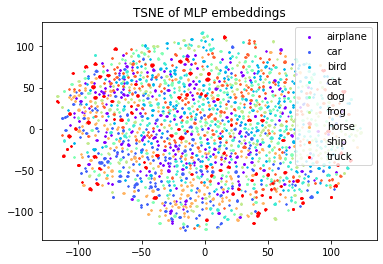

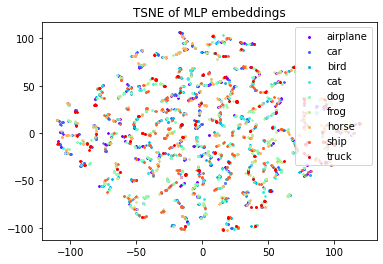

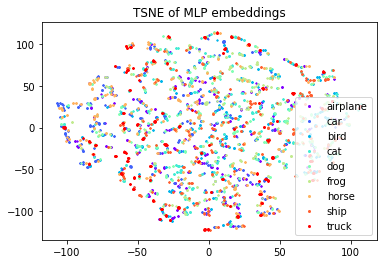

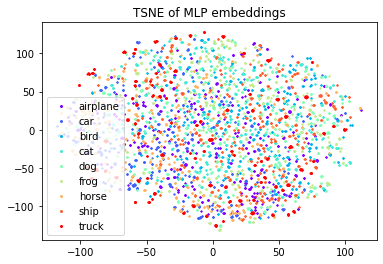

In [124]:
plot_tsne(feats1, labels1, pc=0)
plot_tsne(feats1, labels1, pc=2)
plot_tsne(feats1, labels1, pc=3)
plot_tsne(feats1, labels1, pc=10)

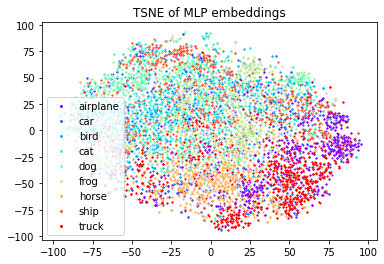

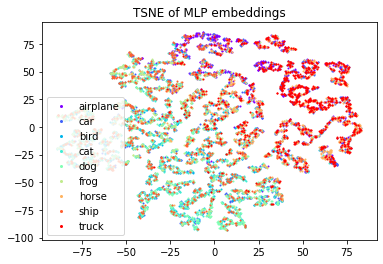

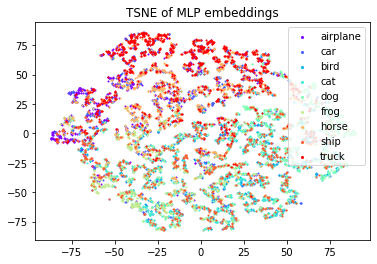

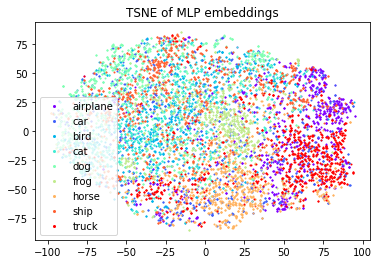

In [125]:
plot_tsne(feats2, labels2, pc=0)
plot_tsne(feats2, labels2, pc=2)
plot_tsne(feats2, labels2, pc=3)
plot_tsne(feats2, labels2, pc=10)

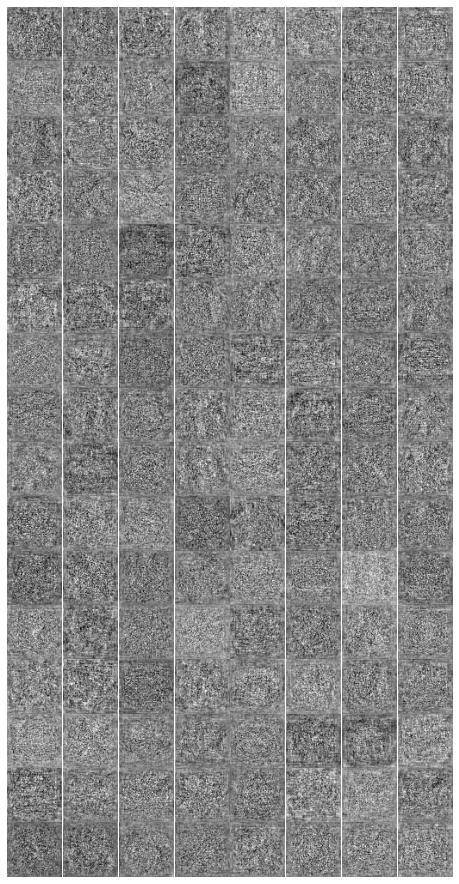

In [167]:
# fig, axs = plt.subplots(16, 32)
row, col = 16, 8
fig, ax = plt.subplots(row, col, figsize=(8,16))
plt.axis('off')
plt.subplots_adjust(hspace=0.001, wspace=0.001)
for r in range(row):
    for c in range(col):
        ax[r,c].axis('off')
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        ax[r,c].imshow(model1.l1.weight.reshape((-1, 64, 64))[r*col + c, :, :].detach(), cmap='gray')
plt.show()

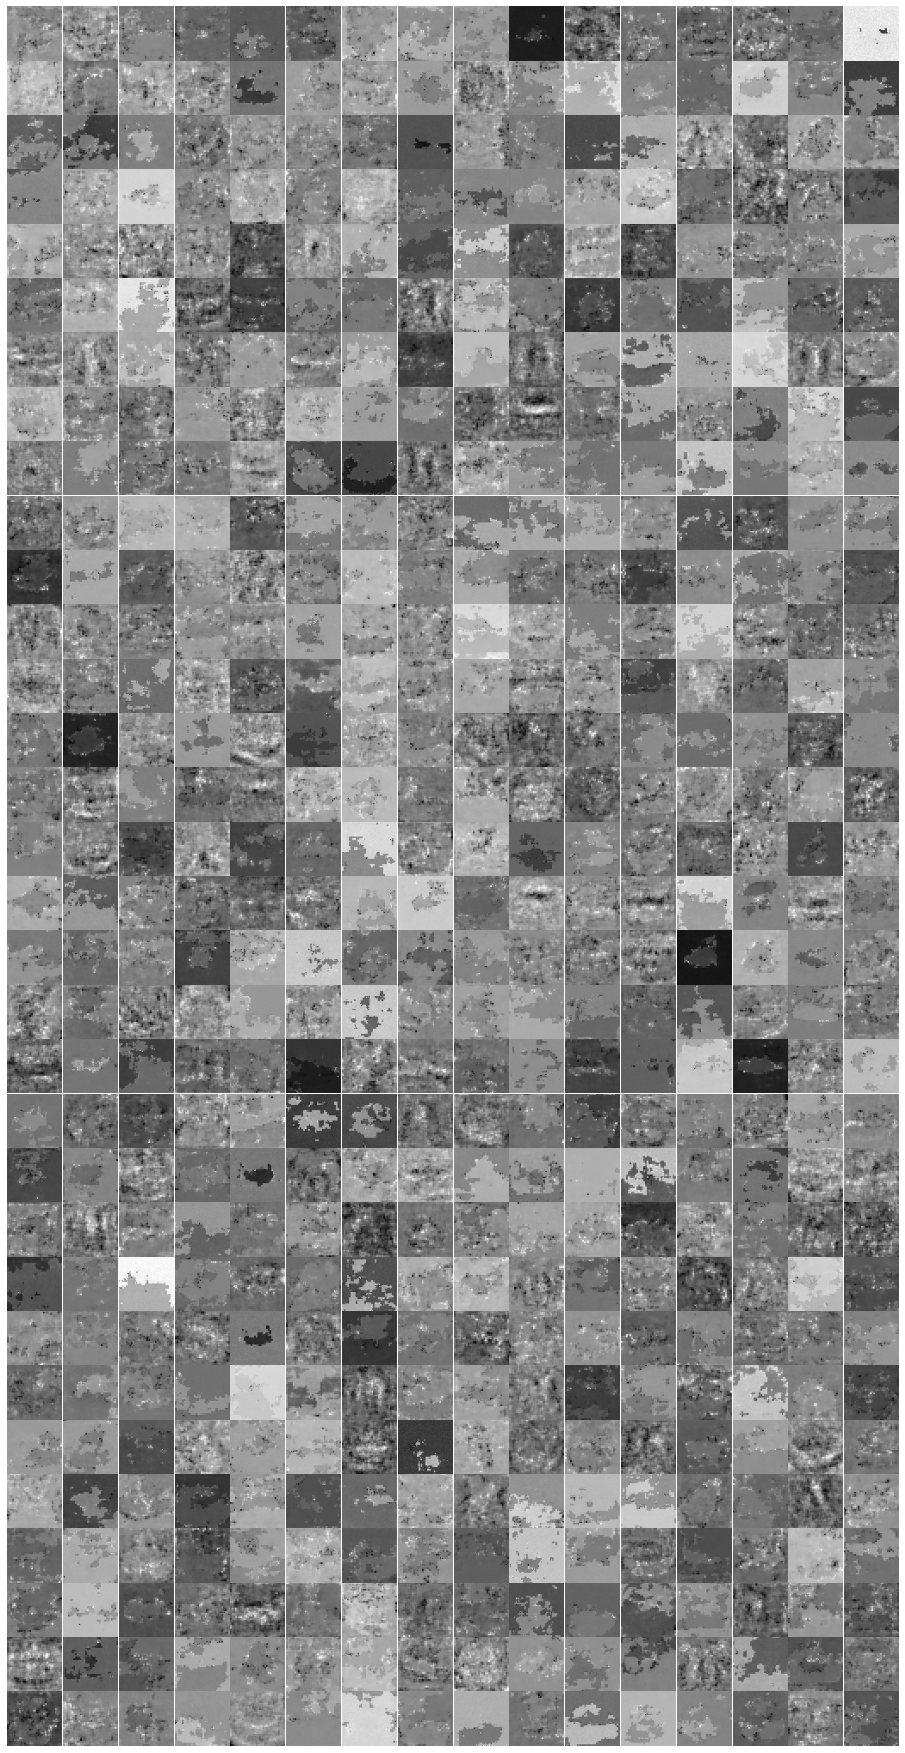

In [166]:
# fig, axs = plt.subplots(16, 32)
row, col = 32, 16
fig, ax = plt.subplots(row, col, figsize=(16,32))
plt.axis('off')
plt.subplots_adjust(hspace=0.001, wspace=0.001)
for r in range(row):
    for c in range(col):
        ax[r,c].axis('off')
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        ax[r,c].imshow(model2.l1.weight.reshape((-1, 3, 64, 64))[r*col + c, 0, :, :].detach(), cmap='gray')
plt.show()